# NDVI Trends

In [9]:
# Import required libraries
import odc.stac
import pandas as pd
import planetary_computer
import pystac_client
import xarray as xr
import hvplot.xarray
import panel as pn
from shapely.geometry import box
import geopandas as gpd
import rioxarray
import numpy as np
from rasterio.mask import mask

## Motivation
Nissim has pointed out potentiality for time series, which I decided to investigate here.
I wrote the code under his guidance.

## Process

In [74]:
def get_datasets(catalog, bbox:list[float], datetime:str, cloudy_less_than:float):
	# Load all selected items (tiles) into a list of datasets
	bands_of_interest = ["red", "green", "blue", "nir", "swir16"]
	datasets = []
	
	search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}}
	)

	items = search.items()
	items = list(items)

	for item in items:

		ds_tile = odc.stac.stac_load(
			items=[item],
			bands=bands_of_interest,
			bbox=bbox,
			resolution=5,
			chunks={},  # Enable Dask for memory efficiency
		)
		datasets.append(ds_tile)

		# Load all selected items (tiles) into a list of datasets
	bands_of_interest = ["red", "green", "blue", "nir", "swir16"]
	datasets = []

	for item in items:
		ds_tile = odc.stac.stac_load(
			items=[item],
			bands=bands_of_interest,
			bbox=bbox,
			resolution=5,
			chunks={},  # Enable Dask for memory efficiency
		)
		datasets.append(ds_tile)
	print("=== completed dataset collection ===")
	return xr.concat(datasets, dim="time")

In [75]:
def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    if red.max() > 1:
        red = red / 10000.0
    if nir.max() > 1:
        nir = nir / 10000.0

    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    # Mask invalid values (divide by zero or NaN)
    # ndvi = np.nan_to_num(ndvi, nan=-9999)  # Replace NaN with a placeholder
    
    # Return
    return np.nanmedian(ndvi)

# NDVI_city = calculate_NDVI(nir, red)
# median_NDVI_city = np.nanmedian(NDVI_city)
# median_NDVI_city

I investigated using the city's median NDVI index using time.

In [ ]:
city_limits = gpd.read_file("./City_Limits.geojson")
city_limits = city_limits.to_crs(32618)

In [ ]:
def ndvi_trends(datasets, clip=city_limits):
	timestamps = datasets.time.values


	res = []
	for timestamp in timestamps:
		print(f"=== Median NDVI calculated for {timestamp} ===")
		query = datasets.sel(time=timestamp).to_array(dim="band").compute()
		query = query.rio.clip([clip], query.rio.crs, drop=True)
		red = query.red.values
		nir = query.nir.values	
		
		res.append(calculate_NDVI(nir, red))
		
		print(f"=== collection complete for {timestamp} ===")
	
	return pd.DataFrame({'timestamp': timestamps, 'median ndvi': res})


In [80]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,  # Automatically signs requests
)
# List available collections
all_collections = [i.id for i in catalog.get_collections()]
sentinel_collections = [collection for collection in all_collections if "sentinel" in collection]
print("Available Sentinel Collections:", sentinel_collections)

# Corrected Query for Sentinel-2 with Cloud Cover Filter
bbox = [-75.2803, 39.8670, -74.9557, 40.1379]  # Philadelphia bounding box
datetime = "2022-08-01/2024-07-31"  # Summer 2024
cloudy_less_than = 10  # Percent cloud cover threshold

Available Sentinel Collections: ['sentinel-1-rtc', 'sentinel-2-l2a', 'sentinel-1-grd', 'sentinel-5p-l2-netcdf', 'sentinel-3-olci-wfr-l2-netcdf', 'sentinel-3-synergy-aod-l2-netcdf', 'sentinel-3-synergy-v10-l2-netcdf', 'sentinel-3-olci-lfr-l2-netcdf', 'sentinel-3-sral-lan-l2-netcdf', 'sentinel-3-slstr-lst-l2-netcdf', 'sentinel-3-slstr-wst-l2-netcdf', 'sentinel-3-sral-wat-l2-netcdf', 'sentinel-3-slstr-frp-l2-netcdf', 'sentinel-3-synergy-syn-l2-netcdf', 'sentinel-3-synergy-vgp-l2-netcdf', 'sentinel-3-synergy-vg1-l2-netcdf']


Took a while, but I did found evidence to suggest that there are fluctuations here after computing the ndvi for each point for the collection

In [81]:
datasets = get_datasets(catalog=catalog, bbox=bbox, datetime=datetime, cloudy_less_than=cloudy_less_than)
trends = ndvi_trends(datasets=datasets)
trends

=== completed dataset collection ===
=== Median NDVI calculated for 2024-07-03T15:48:19.024000000 ===
=== collection complete for 2024-07-03T15:48:19.024000000 ===
=== Median NDVI calculated for 2024-06-28T15:49:41.024000000 ===
=== collection complete for 2024-06-28T15:49:41.024000000 ===
=== Median NDVI calculated for 2024-06-28T15:49:41.024000000 ===
=== collection complete for 2024-06-28T15:49:41.024000000 ===
=== Median NDVI calculated for 2024-06-08T15:49:41.024000000 ===
=== collection complete for 2024-06-08T15:49:41.024000000 ===
=== Median NDVI calculated for 2024-05-31T15:38:09.024000000 ===
=== collection complete for 2024-05-31T15:38:09.024000000 ===
=== Median NDVI calculated for 2024-05-24T15:48:09.024000000 ===
=== collection complete for 2024-05-24T15:48:09.024000000 ===
=== Median NDVI calculated for 2024-05-24T15:48:09.024000000 ===
=== collection complete for 2024-05-24T15:48:09.024000000 ===
=== Median NDVI calculated for 2024-05-21T15:38:09.024000000 ===
=== colle

,time,ndvi
0,2022-08-03 15:48:19.024,0.288339
1,2022-08-03 15:48:19.024,0.295883
2,2022-08-03 15:48:19.024,0.295883
3,2022-08-03 15:48:19.024,0.364068
4,2022-08-03 15:48:19.024,0.330080
...,...,...
172,2022-08-03 15:48:19.024,0.283986
173,2022-08-03 15:48:19.024,0.307239
174,2022-08-03 15:48:19.024,0.307239
175,2022-08-03 15:48:19.024,0.289374


In [84]:
trends['timestamp'] = datasets.time.values

In [82]:
trends.to_parquet('ndvi_trends.parquet')

In [90]:
trends.drop(columns=['time'], inplace=True)
# trends.columns

In [91]:
trends

,ndvi,timestamp
0,0.288339,2024-07-03 15:48:19.024
1,0.295883,2024-06-28 15:49:41.024
2,0.295883,2024-06-28 15:49:41.024
3,0.364068,2024-06-08 15:49:41.024
4,0.330080,2024-05-31 15:38:09.024
...,...,...
172,0.283986,2022-08-18 15:48:21.024
173,0.307239,2022-08-13 15:48:19.024
174,0.307239,2022-08-13 15:48:19.024
175,0.289374,2022-08-03 15:48:19.024


Plot seems to indicate this to be the case.

<Axes: xlabel='timestamp', ylabel='ndvi'>

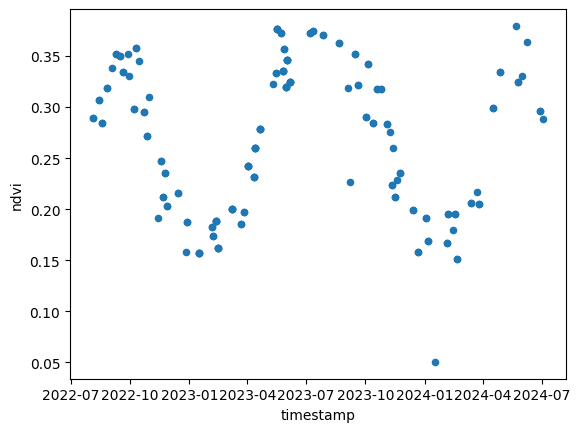

In [92]:
trends.plot.scatter('timestamp', 'ndvi')

So, I fit a quick sinodal curve and plotted it as show below.

Fitted parameters:
offset  = 0.27323722391914057
amplitude = -0.09856554821321882
phase    = -0.9466810455638409


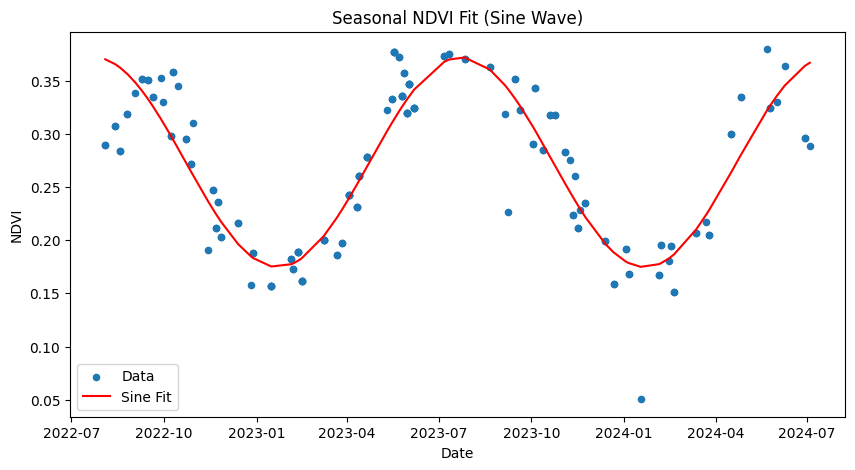

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 1. Define your sinusoidal model
def seasonal_sin(t, offset, amplitude, phase):
    """
    Simple seasonal sine function:
      NDVI(t) = offset + amplitude * sin((2*pi/period)*t + phase)
    """
    period = 365.0  # days, if you expect a 1-year cycle
    return offset + amplitude * np.sin((2 * np.pi / period) * t + phase)

# 2. Convert your timestamps to a numeric scale
#    Suppose 'trends' is a pandas DataFrame with columns 'timestamp' (datetime) and 'ndvi'
trends['t_ordinal'] = trends['timestamp'].map(pd.Timestamp.toordinal)
x = trends['t_ordinal'].values.astype(float)
y = trends['ndvi'].values.astype(float)

# 3. Provide an initial guess for offset, amplitude, and phase
initial_guess = [0.2, 0.1, 0.0]  # for example

# 4. Fit the model
popt, pcov = curve_fit(seasonal_sin, x, y, p0=initial_guess)
offset, amplitude, phase = popt
print("Fitted parameters:")
print("offset  =", offset)
print("amplitude =", amplitude)
print("phase    =", phase)

# 5. Generate fitted values
trends['ndvi_sine_fit'] = seasonal_sin(x, offset, amplitude, phase)

# 6. Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(trends['timestamp'], trends['ndvi'], label='Data', s=20)
plt.plot(trends['timestamp'], trends['ndvi_sine_fit'], color='red', label='Sine Fit')
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.title("Seasonal NDVI Fit (Sine Wave)")
plt.legend()
plt.show()


## Conclusion
- Definitely, a more sinodal pattern here. Potentially, a periodic time series?
- Computation of median ndvi is a drag on the system but not to much at the moment.